<a href="https://colab.research.google.com/github/RVCoelho/Ricardo_Veiga_Coelho/blob/main/ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor: Ricardo Veiga Coelho
email: rvcoelho0@gmail.com
CPF: 449.152.598.62

In [498]:
#escolha o arquivo "Ecommerce_DBS.csv" baixado em https://www.kaggle.com/datasets/raziehghahartars/ecommerce/data
from google.colab import files
uploaded = files.upload()

Saving Ecommerce_DBS.csv to Ecommerce_DBS (1).csv


In [499]:
#Imports que usarei
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns

In [500]:
db = pd.read_csv('Ecommerce_DBS.csv')

In [501]:
#Visualizando colunas para remover as desnecessárias
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   NPS                    250000 non-null  int64  
 7   Customer Age           250000 non-null  int64  
 8   Gender                 250000 non-null  object 
 9   Source                 250000 non-null  object 
 10  Country                250000 non-null  object 
 11  State                  250000 non-null  object 
 12  Latitude               250000 non-null  float64
 13  Longituide             250000 non-null  float64
dtypes: float64(2), int64(6), object(6)
m

In [502]:
#checando categorias da base de dados
db['Product Category'].unique()

array(['Electronics', 'Home', 'Clothing', 'Books'], dtype=object)

# Limpeza de dados

In [503]:
#Removendo colunas desnecessárias
db.drop(columns=['Purchase Date', 'Country', 'State', 'Latitude', 'Longituide'], axis=1, inplace=True)

#Removendo linhas com missing values
db.dropna(inplace=True)

db = db.drop_duplicates()

Renomeação de colunas

In [504]:
db.columns = db.columns.str.lower().str.replace(' ', '_').str.rstrip('_')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   customer_id            250000 non-null  int64 
 1   product_category       250000 non-null  object
 2   product_price          250000 non-null  int64 
 3   quantity               250000 non-null  int64 
 4   total_purchase_amount  250000 non-null  int64 
 5   nps                    250000 non-null  int64 
 6   customer_age           250000 non-null  int64 
 7   gender                 250000 non-null  object
 8   source                 250000 non-null  object
dtypes: int64(6), object(3)
memory usage: 17.2+ MB


Criação de faixas etárias

In [505]:
bins = [18, 28, 39, 49, 59, 69, 100]
labels = ['18-28', '29-39', '39-49', '49-59', '59-69', '70+']

db['age_group'] = pd.cut(db['customer_age'], bins=bins, labels=labels, right=False)

# Criação de bases de dados separados por categorias para uso de análises futuras

In [506]:
home = db[db['product_category'] == 'Home']
electronics = db[db['product_category'] == 'Electronics']
books = db[db['product_category'] == 'Books']
clothing = db[db['product_category'] == 'Clothing']

# 1) Quais os produtos mais vendidos considerando os últimos 3 anos?

In [507]:
#Achando produtos mais vendidos dos últimos 3 anos (2020 à 2022)
#Como não temos código do produto nem nome do produto, a minha estratégia será pegar produtos de mesma categoria e preço e assumir que são iguais quando essas duas colunas forem iguais.
#No entanto é importante ressaltar que é possível que diferentes produtos de mesma categoria tenham o mesmo preço, o que pode gerar resultados incorretos em análise de outras colunas, como por exemplo, NPS de um suposto produto, pois se ocorrer esse caso, podem ser produtos diferentes de mesmo preço com NPS médio bem diferentes

top_products = db.groupby(["product_category", "product_price"]).count()
top10_products = top_products.sort_values(by="total_purchase_amount", ascending=False).head(10).filter(items=["product_category", "product_price", "total_purchase_amount"]).reset_index()
top10_products.style.set_caption("10 produtos mais vendidos")

,product_category,product_price,total_purchase_amount
0,Books,48,192
1,Books,86,188
2,Clothing,398,187
3,Clothing,202,186
4,Books,197,185
5,Clothing,45,185
6,Clothing,28,185
7,Books,365,184
8,Books,308,184
9,Clothing,407,183


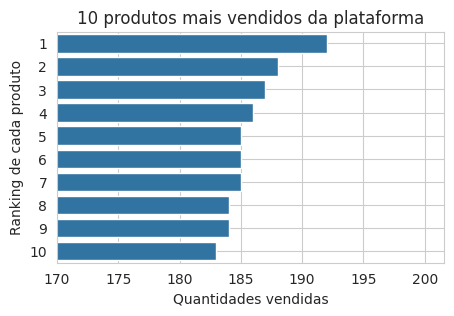

In [508]:
top10_products['position'] = range(1, len(top10_products) + 1)

plt.figure(figsize=(5,3))
sns.barplot(data=top10_products, y='position', x='total_purchase_amount', orient='h')
plt.title('10 produtos mais vendidos da plataforma')
plt.xlabel('Quantidades vendidas')
plt.ylabel('Ranking de cada produto')
plt.xlim(170, None)
plt.grid(True)
plt.show()

Interpretação de linhas: o livro de preço 48 vendeu 192 unidades, e assim por diante.

In [509]:
#Também poderiam ser simplesmente as linhas com maiores valores de "Total Purchase Amount", mas creio que isso indique a quantidade total de compras por Customer ID, e não quantidade total de mesmo produto vendido, portanto ignorarei essa possibilidade
#db.sort_values(by="Total Purchase Amount", ascending=False).head(10)

# 2) Qual o produto mais caro e o mais barato?

In [510]:
#Produto mais caro:
idx = db["product_price"].idxmax()
db_maior_preco = db.loc[idx]
print(db_maior_preco)

customer_id                          30759
product_category               Electronics
product_price                          500
quantity                                 5
total_purchase_amount                 4498
nps                                      7
customer_age                            21
gender                              Female
source                   Instagram Campign
age_group                            18-28
Name: 560, dtype: object


In [511]:
#Conversão pra Series, pegando apenas o que identifica o produto: categoria e preço
serie = pd.Series(db_maior_preco)
produto_mais_caro = serie[['product_category', 'product_price']]
print(produto_mais_caro)

product_category    Electronics
product_price               500
Name: 560, dtype: object


Produto mais caro: eletrônico de valor 500.

In [512]:
#Produto mais barato
idx = db["product_price"].idxmin()
db_menor_preco = db.loc[idx]
print(db_menor_preco)

customer_id                          20078
product_category               Electronics
product_price                           10
quantity                                 3
total_purchase_amount                 4274
nps                                      9
customer_age                            21
gender                                Male
source                   Instagram Campign
age_group                            18-28
Name: 1128, dtype: object


In [513]:
#Conversão pra Series, pegando apenas o que identifica o produto: categoria e preço
serie = pd.Series(db_menor_preco)
produto_mais_barato = serie[['product_category', 'product_price']]
print(produto_mais_barato)

product_category    Electronics
product_price                10
Name: 1128, dtype: object


Produto mais barato: eletrônico de valor 10.

# 3) Qual a categoria de produto mais vendida e menos vendida? Qual a categoria mais e menos cara?

In [514]:
#Categorias mais e menos vendida
categories_ranked_by_sold_volume = db.groupby("product_category").count().sort_values(by="total_purchase_amount", ascending=False).filter(items=["product_category", "total_purchase_amount"])
categories_ranked_by_sold_volume

,total_purchase_amount
product_category,
Clothing,75052
Books,74912
Electronics,50185
Home,49851


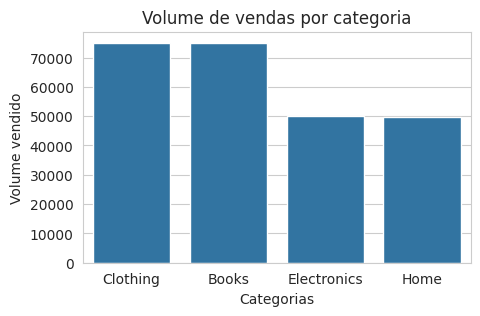

In [515]:
plt.figure(figsize=(5,3))
sns.barplot(data=categories_ranked_by_sold_volume, x='product_category', y='total_purchase_amount', orient='v')
plt.title('Volume de vendas por categoria')
plt.xlabel('Categorias')
plt.ylabel('Volume vendido')
plt.show()

Categoria mais vendida: roupas, porém praticamente empatado com livros

Categoria menos vendida: casa, porém praticamente empatado com eletrônicos

In [516]:
#Categorias mais e menos caras
categories_ranked_by_average_price = db.groupby("product_category")["product_price"].mean().round(3).reset_index().sort_values(by="product_price", ascending=False)
categories_ranked_by_average_price

,product_category,product_price
3,Home,254.842
2,Electronics,254.723
0,Books,254.709
1,Clothing,254.446


In [517]:
percentiles = [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

In [518]:
home['product_price'].quantile(percentiles)

0.25    132.0
0.50    256.0
0.75    377.0
0.90    451.0
0.95    476.0
0.99    496.0
Name: product_price, dtype: float64

In [519]:
electronics['product_price'].quantile(percentiles)

0.25    132.0
0.50    254.0
0.75    377.0
0.90    451.0
0.95    476.0
0.99    495.0
Name: product_price, dtype: float64

In [520]:
books['product_price'].quantile(percentiles)

0.25    132.0
0.50    255.0
0.75    377.0
0.90    451.0
0.95    476.0
0.99    495.0
Name: product_price, dtype: float64

In [521]:
clothing['product_price'].quantile(percentiles)

0.25    132.0
0.50    254.0
0.75    378.0
0.90    450.0
0.95    475.0
0.99    495.0
Name: product_price, dtype: float64

Como as distribuições de preços são extremamente semelhantes, não é possível determinar uma categoria mais cara e mais barata, pois são todas praticamente iguais ao todo.

# 4) Qual o produto com melhor e pior NPS?

In [522]:
db.groupby(["product_category", "product_price"])["nps"].mean().round(3).reset_index().sort_values(by="nps", ascending=False).filter(items=["product_category", "product_price", "nps"])

,product_category,product_price,nps
1527,Home,64,6.157
1482,Home,19,6.049
1093,Electronics,121,6.021
725,Clothing,244,5.880
517,Clothing,36,5.864
...,...,...,...
1406,Electronics,434,4.139
1835,Home,372,4.130
1446,Electronics,474,4.127
1935,Home,472,4.106


Produto com melhor NPS: produto da categoria casa de valor 64 com NPS médio de 6,157

Produto com pior NPS: produto da categoria de eletrônicos de valor 64 com NPS médio de 4,065

# Analisando a base de dados, qual o tipo de público (considerando gênero e idade) e o canal ideal para vender determinado tipo de produto?

Primeiramente irei verificar o tipo de distribuição de faxas etárias para checar se há faixas etárias mais prevalecentes.

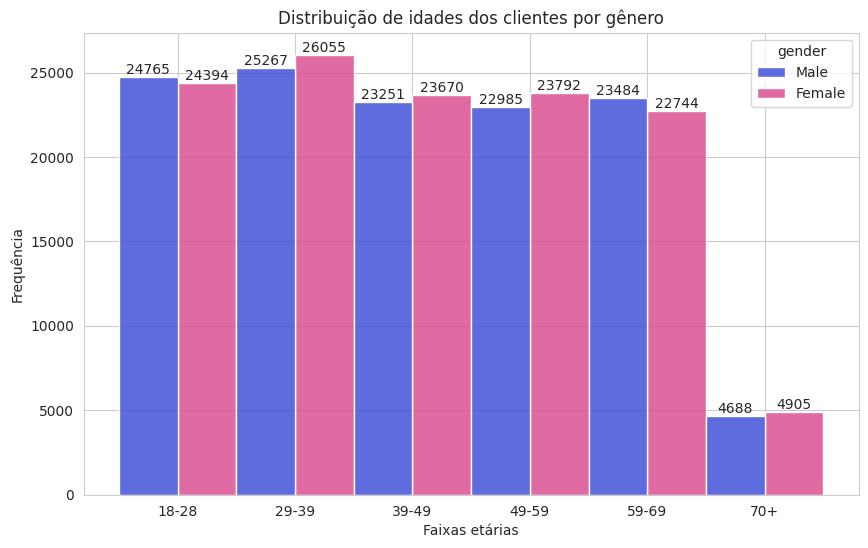

In [526]:
plt.figure(figsize=(10,6))
plot = sns.histplot(data=db, x='age_group', hue='gender', multiple='dodge', palette={'Male': '#2a3bd4', 'Female': '#d63a85'})
plt.title('Distribuição de idades dos clientes por gênero')
plt.xlabel('Faixas etárias')
plt.ylabel('Frequência')
plt.grid(True)
for i in plot.containers:
    plot.bar_label(i)
plt.show()

Não é possível determinar um público alvo geral pois a distribuição é muito uniforme entre ambos gêneros e faixas etárias.




# E o canal ideal para vender cada produto?

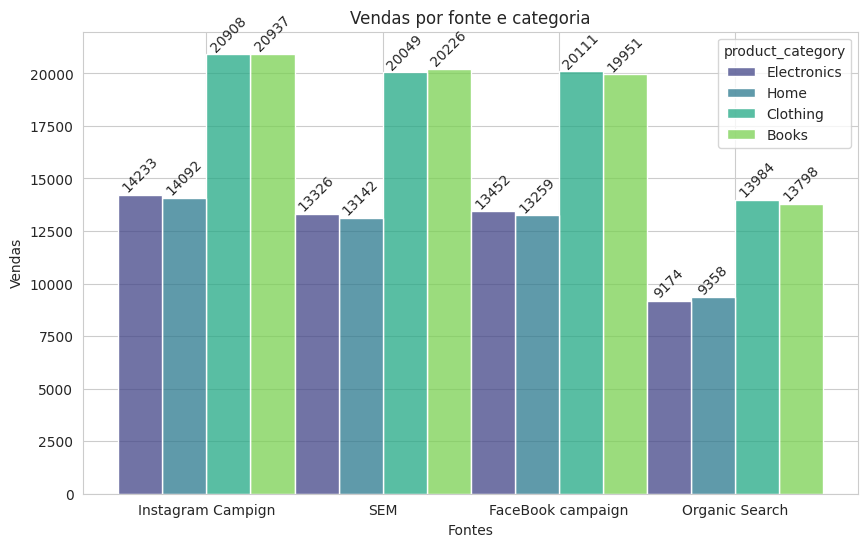

In [527]:
plt.figure(figsize=(10,6))
plot = sns.histplot(data=db, x='source', hue='product_category', multiple='dodge', palette='viridis')
plt.title('Vendas por fonte e categoria')
plt.xlabel('Fontes')
plt.ylabel('Vendas')
plt.grid(True)
for i in plot.containers:
    plot.bar_label(i, rotation=45)
plt.show()

Podemos ver que apenas pesquisa ôrganica fica abaixo das outras fontes, que tem, entre si, desempenho bastante similar para cada categoria. Portanto também não é possível determinar um canal ideal

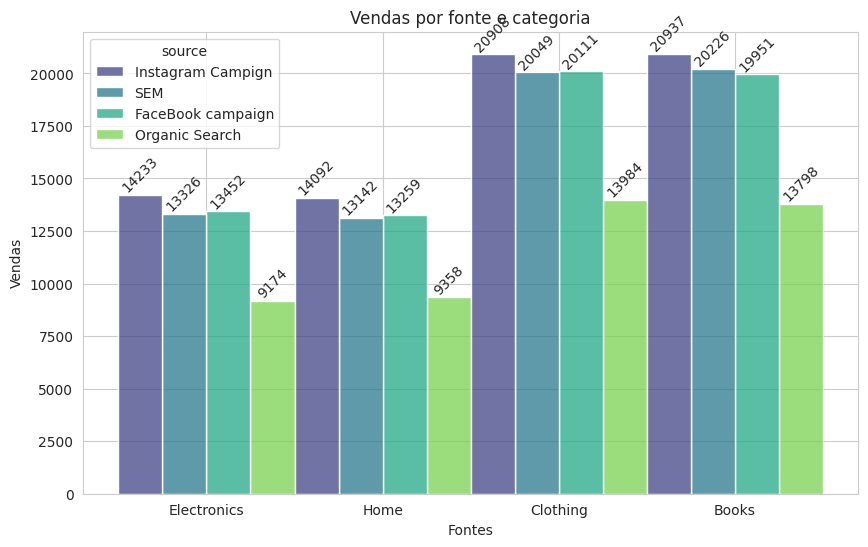

In [528]:
plt.figure(figsize=(10,6))
plot = sns.histplot(data=db, x='product_category', hue='source', multiple='dodge', palette='viridis')
plt.title('Vendas por fonte e categoria')
plt.xlabel('Fontes')
plt.ylabel('Vendas')
plt.grid(True)
for i in plot.containers:
    plot.bar_label(i, rotation=45)
plt.show()

Fazendo o gráfico trocando fonte por categoria de produto, podemos ver mais claramente que também não há muita diferença de desempenho entre as 3 melhores fontes para cada categoria, mas que o instagram tem um desempenho levemente superior que as outras duas.

# Conclusões

A distribuição não permite que determinemos público alvo considerando gênero e idade devido à uniformidade da distribuição, e nem canal ideal, devido ao desempenho muito semelhante entre instagram, SEM e facebook.

O único insight verdadeiramente útil que conseguimos extrair dessa análise é que o gráfico de volume de vendas por categoria mostra claramente que as categorias de livros e roupas são as que tem maior sucesso.